In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
import pandas as pd
import numpy as np

# basins

In [2]:
file_shp = '/glade/work/guoqiang/CTSM_CAMELS/data_shp/gagesII_671_shp_geogr.gpkg'
shp = gpd.read_file(file_shp)

In [4]:
file_level1 = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df1 = pd.read_csv(file_level1)

In [8]:
shp1 = shp[shp['hru_id'].isin(df1['hru_id'])]

In [14]:
dem_file = '/glade/campaign/cgd/tss/people/guoqiang/DEM/hyd_na_dem_15s.tif'
# Open the DEM file
dem_data = gdal.Open(dem_file)
dem_array = dem_data.ReadAsArray()

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


<GeoAxes: >

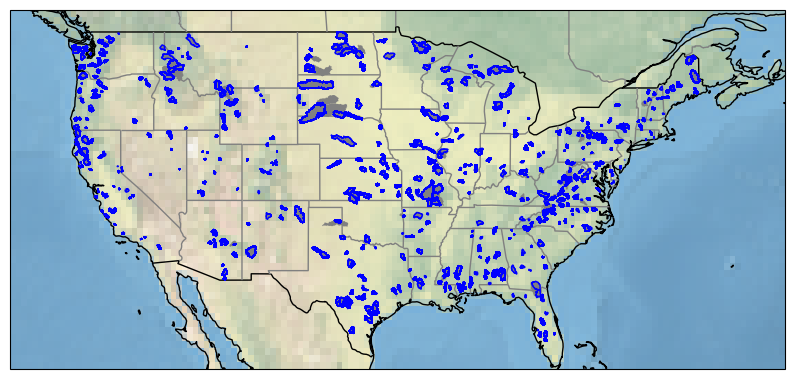

In [11]:
plt.figure(figsize=[10, 6])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -60, 25, 45])

# Put a background image on for nice sea rendering.
ax.stock_img()

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

# Background boundaries
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# basins
shp.plot(ax=ax, color='grey')

# selected basins
shp1.boundary.plot(ax=ax, color='b', linewidth=1)

# plt.savefig('CAMELS_basins.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

# Clusters

In [6]:
infile = '../src/camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt'
df_cluster = pd.read_csv(infile)

file_level1 = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file_level1)

In [11]:
df_cluster = df_cluster.rename(columns={'Camels_IDs':'hru_id', 'flood_cluster':'clusters'})
df_cluster2 = pd.DataFrame()

for id in df_info['hru_id'].values:
    dfi = df_cluster.loc[df_cluster['hru_id']==id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster['clusters'] = df_cluster['clusters'] - 1 # starting from 0

if np.any( (df_info['hru_id'] - df_cluster['hru_id']).values !=0 ):
    print('Mistmatch between basins and clusters')
else:
    print('basins and clusters match')

basins and clusters match


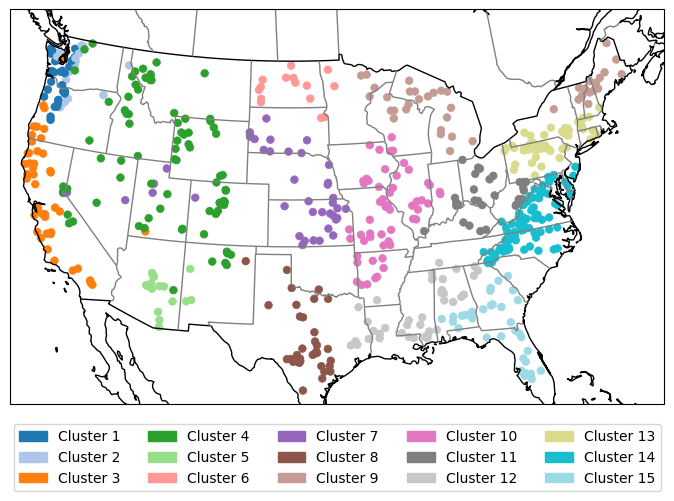

In [56]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
import pandas as pd

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax
    
lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values

# Create the figure
fig = plt.figure(figsize=[7.5, 5])

# Define the projection (Albers Equal Area) and the transformation (PlateCarree for lat/lon)
proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

# Create the subplot with the defined projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax = set_background(ax)

# Add a scatter plot of the clusters with color-coding
scatter = ax.scatter(lon, lat, c=df_cluster['clusters'], cmap='tab20', s=30, linewidth=0.5, transform=transf)

# Create a legend for the clusters
legend_labels = {int(cluster): mpatches.Patch(color=color, label=f'Cluster {int(cluster+1)}')
                 for cluster, color in zip(df_cluster['clusters'], scatter.cmap(scatter.norm(scatter.get_array())))}
handles = [legend_labels[cluster] for cluster in range(15)]  # Adjust for the number of clusters

# Place the legend below the figure
plt.legend(handles=handles, bbox_to_anchor=(0.5, -0.05), loc='upper center', borderaxespad=0, ncol=5, fontsize=10)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to avoid overlapping with the legend
plt.tight_layout()

# Show the plot
# plt.show()

plt.savefig('basin_clusters.png', dpi=600, bbox_inches='tight', pad_inches=0)